# Ejemplo 3, Renta de bicicletas

Problema de Regresion

El objetivo es predecir el uso del alquiler de bicicletas basado en datos como la temperatura, humedad, velocidad del viento, etc

Red de perceptrón multicapa

variables:
* instant : indice de registro
* dteday : fecha
* season : temporada: 1:primavera - 2:verano - 3:invierno
* yr : año : 0:2011 - 1:2012
* mnth : mes 
* holiday : dia festivo 1:si - 0:no
* weekday : dia ade la semana
* workingday : 1 en semana - 0 en fin de semana o festivo
* weathersit : clima : 
                        ** 1:despejado
                        ** 2:nublado
                        ** 3:lluvia ligera
                        ** 4:lluvia fuerte
* temp : temperatura en °c
* hum : humedad
* windspeed : velocidad del viento

salidas - TARGET

* casual : recuento de usuarios casuales
* registered : recuento de usuarios registrados
* cnt : conteo total de bicicletas alquiladas

In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')


#Importando Set de Datos
bike = pd.read_csv("rentas_bicis.csv")

display(HTML(bike.to_html()))


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt
0,1,1/1/2011,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,331,654,985
1,2,1/2/2011,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,131,670,801
2,3,1/3/2011,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,120,1229,1349
3,4,1/4/2011,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,108,1454,1562
4,5,1/5/2011,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,82,1518,1600
5,6,1/6/2011,1,0,1,0,4,1,1,0.204348,0.518261,0.089565,88,1518,1606
6,7,1/7/2011,1,0,1,0,5,1,2,0.196522,0.498696,0.168726,148,1362,1510
7,8,1/8/2011,1,0,1,0,6,0,2,0.165000,0.535833,0.266804,68,891,959
8,9,1/9/2011,1,0,1,0,0,0,1,0.138333,0.434167,0.361950,54,768,822
9,10,1/10/2011,1,0,1,0,1,1,1,0.150833,0.482917,0.223267,41,1280,1321


In [2]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  hum         731 non-null    float64
 11  windspeed   731 non-null    float64
 12  casual      731 non-null    int64  
 13  registered  731 non-null    int64  
 14  cnt         731 non-null    int64  
dtypes: float64(3), int64(11), object(1)
memory usage: 85.8+ KB


,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
dteday,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.805833,0.160446,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.696087,0.248539,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.437273,0.248309,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.590435,0.160296,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.436957,0.186900,1600
2011-01-06,1,0,1,0,4,1,1,0.204348,0.518261,0.089565,1606
2011-01-07,1,0,1,0,5,1,2,0.196522,0.498696,0.168726,1510
2011-01-08,1,0,1,0,6,0,2,0.165000,0.535833,0.266804,959
2011-01-09,1,0,1,0,0,0,1,0.138333,0.434167,0.361950,822


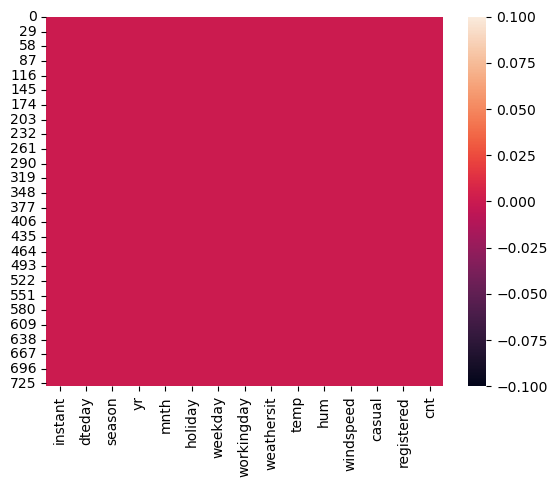

In [3]:
#LIMPIEZA DE DATOS (no necesaria)
sns.heatmap(bike.isnull())

#Limpiando Columnas que no interesan
bike = bike.drop(labels = ['instant'], axis= 1)
# 1 IA por target, conservo solo el total
bike = bike.drop(labels = ['casual', 'registered'], axis= 1) 

#Formato de Fecha
bike.dteday = pd.to_datetime(bike.dteday, format = '%m/%d/%Y')

#DateTime como Index
bike.index = pd.DatetimeIndex(bike.dteday)
bike = bike.drop(labels = ['dteday'], axis= 1)

display(HTML(bike.to_html()))


semana : azul 
Mes: naranja 
Trimestre : verde 


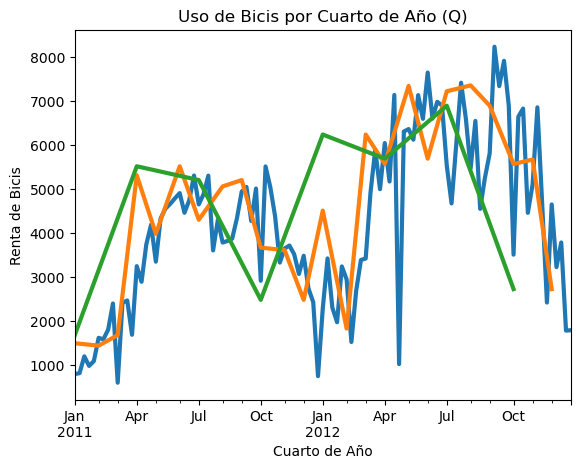

In [4]:

#VISUALIZACION
'''
La función asfreq() en pandas se utiliza para convertir una serie temporal
a una frecuencia especificada.
Se cambia la frecuencia de la columna 'cnt' en el DataFrame 'bike'
a semanal (marcada como 'W').
Si faltan marcas de tiempo en la columna 'cnt', las rellenará basándose
en el método especificado (que no se proporciona en este caso, por lo
que utilizará el método por defecto).
'''


bike['cnt'].asfreq('W').plot(linewidth = 3)
plt.title('Uso de Bicis por Semana (W)')
plt.xlabel('Semana')
plt.ylabel('Renta de Bicis')

bike['cnt'].asfreq('M').plot(linewidth = 3)
plt.title('Uso de Bicis por Mes (M)')
plt.xlabel('Mes')
plt.ylabel('Renta de Bicis')

bike['cnt'].asfreq('Q').plot(linewidth = 3)
plt.title('Uso de Bicis por Cuarto de Año (Q)')
plt.xlabel('Cuarto de Año')
plt.ylabel('Renta de Bicis')

print("semana : azul \nMes: naranja \nTrimestre : verde ")


#plt.legend()


### Correlacion de los datos

<AxesSubplot:>

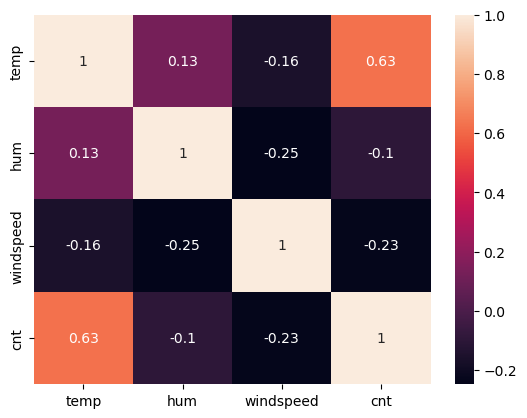

In [5]:
#Datos Categoricos y Numericos
#Datos Numericos
X_numerical = bike[['temp', 'hum', 'windspeed', 'cnt']]

#Encontrando Correlacion en Datos Numericos
sns.heatmap(X_numerical.corr(), annot = True)


### Preprocesado de los datos

In [6]:
#Datos Categoricos
X_cat = bike[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']]

# Binarizacion
onehotencoder = OneHotEncoder()
X_cat = onehotencoder.fit_transform(X_cat).toarray()
X_cat = pd.DataFrame(X_cat)

#df con los datos categorizados
X_numerical = X_numerical.reset_index()
X_all = pd.concat([X_cat, X_numerical], axis = 1)
X_all = X_all.drop('dteday', axis = 1)
X = X_all.iloc[:, :-1].values
y = X_all.iloc[:, -1:].values # slicing target

# Escalado
scaler = MinMaxScaler()
y = scaler.fit_transform(y)

#Sepaarar set de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#Definiendo Modelo
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=100, activation='relu', input_shape=(35, )))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=100, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

'''
'linear': Linear activation function (default)
'relu': Rectified Linear Unit activation function
'sigmoid': Sigmoid activation function
'tanh': Hyperbolic Tangent activation function
'softmax': Softmax activation function
'softplus': Softplus activation function
'softsign': Softsign activation function
'leaky_relu': Leaky ReLU activation function
'selu': SELU activation function
'elu': ELU activation function
'gelu': GELU activation function
'''


model.summary()

#Compilado
model.compile(optimizer='Adam', loss='mean_squared_error')

#Entrenamiento
epochs_hist = model.fit(X_train, y_train, epochs = 20, batch_size = 50, validation_split = 0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │           3,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,901 (93.36 KB)

 Trainable params: 23,901 (93.36 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2071 - val_loss: 0.0601
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333 - val_loss: 0.0313
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0199 - val_loss: 0.0173
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0150 - val_loss: 0.0151
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0140
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.0138
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.0137
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0134
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0132
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0050 - val_loss: 0.0135
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044 - val_loss: 0.0132
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - val_l

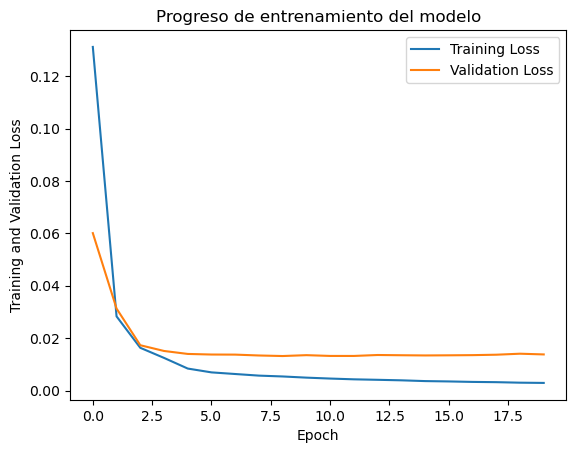

In [8]:
#Prediccion
epochs_hist.history.keys()


#Grafico
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Progreso de entrenamiento del modelo')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])




5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Text(0, 0.5, 'Valores Verdaderos')

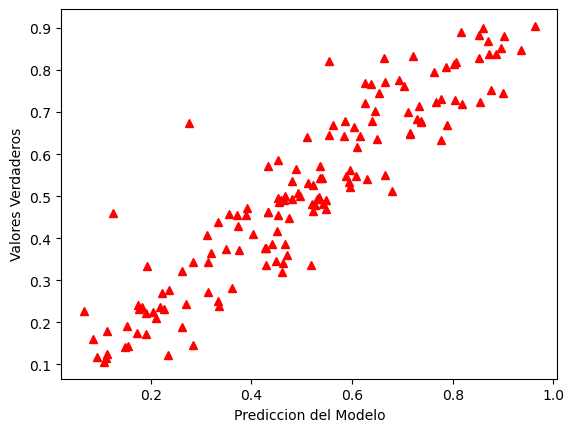

In [9]:
#Prediccion
y_predict = model.predict(X_test)
plt.plot(y_test, y_predict, "^", color = 'r')
plt.xlabel('Prediccion del Modelo')
plt.ylabel('Valores Verdaderos')

<AxesSubplot:xlabel='temp', ylabel='cnt'>

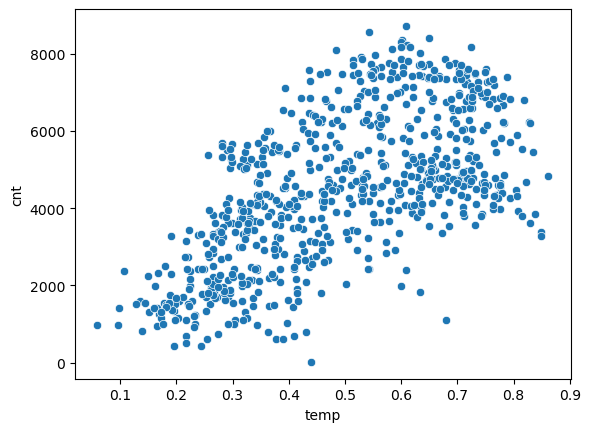

In [12]:
# para comparar:
#grafico de dispersion de los datos originales en relacion clima/conteo de bicicletas

sns.scatterplot(bike['temp'], bike['cnt'])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Text(0, 0.5, 'Valores Verdaderos')

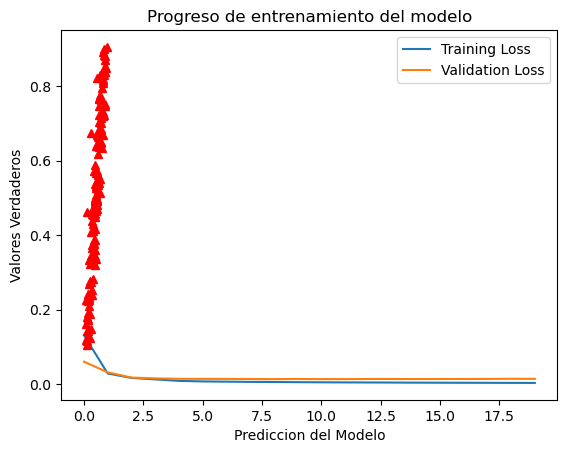

In [10]:
# uniendo ambas graficas 

#Grafico
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Progreso de entrenamiento del modelo')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(['Training Loss', 'Validation Loss'])

#Prediccion
y_predict = model.predict(X_test)
plt.plot(y_test, y_predict, "^", color = 'r')
plt.xlabel('Prediccion del Modelo')
plt.ylabel('Valores Verdaderos')

In [18]:
#evaluar el rendimiento del modelo

loss= model.evaluate(X_test, y_test)
print(f'Test loss: {loss:.3f}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0088 
Test loss: 0.008


In [16]:
#Predicciones
pred=pd.DataFrame(y_predict)
pred.columns = ['Pred']
real=pd.DataFrame(y_test)
real.columns = ['real']
real = real.reset_index(drop=True)
result = pd.concat([pred, real], axis=1)
print("recuerden que a este punto los datos estan escalados")
result

recuerden que a este punto los datos estan escalados


,Pred,real
0,0.173094,0.191325
1,0.438937,0.332605
2,0.848799,0.935803
3,0.616483,0.608951
4,0.820764,0.554303
...,...,...
142,0.456749,0.355844
143,0.335951,0.517602
144,0.530707,0.512310
145,0.336400,0.428900


In [20]:
#Revirtiendo Escalado para apreciar el precio correctamente escalado
pred_unscal = scaler.inverse_transform(y_predict)
real_unscal = scaler.inverse_transform(y_test)

#Predicciones
pred=pd.DataFrame(pred_unscal)
pred.columns = ['Pred']
real=pd.DataFrame(real_unscal)
real.columns = ['real']
real = real.reset_index(drop=True)
result = pd.concat([pred, real], axis=1)
print("recuerden que a este punto los datos estan escalados")
result

recuerden que a este punto los datos estan escalados


,Pred,real
0,1526.530640,1685.0
1,3837.238037,2913.0
2,7399.763672,8156.0
3,5380.468750,5315.0
4,7156.084961,4840.0
...,...,...
142,3992.066650,3115.0
143,2942.087402,4521.0
144,4634.901367,4475.0
145,2945.988525,3750.0
